# Hard Decoy & AlphaPeptDeep

Take a AlphaPeptDeepModel and find optimal decoys

In [1]:
#To install alphapeptdeep:
# !pip install peptdeep

In [2]:
import os
import alphabase.psm_reader

ap_ms_data_hdf = os.path.expanduser('thermo_HeLa.ms_data.hdf')

from alphabase.psm_reader import psm_reader_provider

modification_mapping = {
    'Carbamidomethyl@C': 'cC',
    'Oxidation@M': 'oxM',
    'Phospho@S': 'pS',
    'Phospho@T': 'pT',
    'Phospho@Y': 'pY',
    'Acetyl@Protein N-term': 'a',
}

reader = psm_reader_provider.get_reader('alphapept', modification_mapping=modification_mapping)
reader.import_file(ap_ms_data_hdf)
reader.psm_df

,rt,scan_num,spec_idx,query_id,score,precursor_mz,charge,raw_name,fdr,decoy,sequence,mods,mod_sites,nAA,rt_norm
0,30.666735,30372,30371,33911,0.746479,734.336584,1,thermo_HeLa,0.008326,0,MVGEEK,Acetyl@Protein N-term,0,6,0.283704
1,19.199168,15149,15148,36593,0.729620,750.297000,1,thermo_HeLa,0.008965,0,MDGEEK,Acetyl@Protein N-term,0,6,0.177616
2,46.254090,50591,50590,13042,0.973603,591.273605,1,thermo_HeLa,0.000468,0,GDGTGGK,,,7,0.427906
3,71.681161,83116,83115,55124,0.906001,428.778498,2,thermo_HeLa,0.003252,0,ELIQLIK,,,7,0.663138
4,66.380406,76370,76369,55136,0.951621,428.778779,2,thermo_HeLa,0.001333,0,LELLLQK,,,7,0.614099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53404,90.829107,107111,107110,243092,0.968726,984.154252,3,thermo_HeLa,0.000625,0,ALTQPSPVSTPSSVQFFLQEDDSADRK,,,27,0.840279
53405,100.350276,118858,118857,243124,0.993184,986.805330,3,thermo_HeLa,0.000000,0,YLAGADPSTVEMCYPPIIQSGGNYNLK,Carbamidomethyl@C,13,27,0.928362
53406,100.413714,118949,118948,240398,0.992892,898.792924,3,thermo_HeLa,0.000000,0,AVPTWASVQVVDDPGSLASVESPGTPK,,,27,0.928949
53407,97.679287,115509,115508,243016,0.991619,980.496315,3,thermo_HeLa,0.000000,0,AIPLVLVSGNHDIGNTPTAETVEEFCR,Carbamidomethyl@C,26,27,0.903652


In [3]:
from peptdeep.pretrained_models import ModelManager

models = ModelManager()
models.load_installed_models()


rt_model = models.rt_model
rt_model.get_parameter_num()

708224

In [4]:
predict_df = rt_model.predict(reader.psm_df)

<AxesSubplot:>

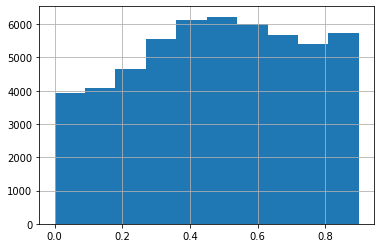

In [5]:
predict_df['rt_pred'].hist()

In [6]:
#from alphapept
from numba import njit
from numba.typed import List

@njit
def parse(peptide:str)->List:
    """
    Parser to parse peptide strings
    Args: 
        peptide (str): modified peptide sequence.
    Return:
        List (numba.typed.List): a list of animo acids and modified amono acids
    """
    if "_" in peptide:
        peptide = peptide.split("_")[0]
    parsed = List()
    string = ""

    for i in peptide:
        string += i
        if i.isupper():
            parsed.append(string)
            string = ""

    return parsed

def list_to_numba(a_list) -> List:
    """
    Convert Python list to numba.typed.List
    Args: 
        a_list (list): Python list.
    Return:
        List (numba.typed.List): Numba typed list.
    """
    numba_list = List()

    for element in a_list:
        numba_list.append(element)

    return numba_list

# %% ../nbs/03_fasta.ipynb 17
@njit
def get_decoy_sequence(peptide:str, pseudo_reverse:bool=False, AL_swap:bool=False, KR_swap:bool = False)->str:
    """
    Reverses a sequence and adds the '_decoy' tag.
    Args:
        peptide (str): modified peptide to be reversed.
        pseudo_reverse (bool): If True, reverse the peptide bug keep the C-terminal amino acid; otherwise reverse the whole peptide. (Default: False)
        AL_swap (bool): replace A with L, and vice versa. (Default: False)
        KR_swap (bool): replace K with R at the C-terminal, and vice versa. (Default: False)
    Returns:
        str: reversed peptide ending with the '_decoy' tag.
    """
    pep = parse(peptide)
    if pseudo_reverse:
        rev_pep = pep[:-1][::-1]
        rev_pep.append(pep[-1])
    else:
        rev_pep = pep[::-1]

    if AL_swap:
        rev_pep = swap_AL(rev_pep)

    if KR_swap:
        rev_pep = swap_KR(rev_pep)

    rev_pep = "".join(rev_pep)

    return rev_pep


@njit
def swap_KR(peptide:str)->str:
    """
    Swaps a terminal K or R. Note: Only if AA is not modified.
    
    Args:
        peptide (str): peptide.
    Returns:
        str: peptide with swapped KRs.
    """
    if peptide[-1] == 'K':
        peptide[-1] = 'R'
    elif peptide[-1] == 'R':
        peptide[-1] = 'K'

    return peptide


@njit
def swap_AL(peptide:str)->str:
    """
    Swaps a A with L. Note: Only if AA is not modified.
    Args:
        peptide (str): peptide.
    Returns:
        str: peptide with swapped ALs.
    """
    i = 0
    while i < len(range(len(peptide) - 1)):
        if peptide[i] == "A":
            peptide[i] = peptide[i + 1]
            peptide[i + 1] = "A"
            i += 1
        elif peptide[i] == "L":
            peptide[i] = peptide[i + 1]
            peptide[i + 1] = "L"
            i += 1
        i += 1

    return peptide

In [7]:
#Try different decoys

psdm_df_test1 = reader.psm_df.copy()
psdm_df_test1['sequence'] = psdm_df_test1['sequence'].apply(lambda x: get_decoy_sequence(x, pseudo_reverse=True))
predict_df_test1 = rt_model.predict(psdm_df_test1)

psdm_df_test2 = reader.psm_df.copy()
psdm_df_test2['sequence'] = psdm_df_test2['sequence'].apply(lambda x: get_decoy_sequence(x, pseudo_reverse=False))
predict_df_test2 = rt_model.predict(psdm_df_test2)

psdm_df_test3 = reader.psm_df.copy()
psdm_df_test3['sequence'] = psdm_df_test3['sequence'].apply(lambda x: get_decoy_sequence(x, AL_swap=True))
predict_df_test3 = rt_model.predict(psdm_df_test3)

psdm_df_test4 = reader.psm_df.copy()
psdm_df_test4['sequence'] = psdm_df_test4['sequence'].apply(lambda x: get_decoy_sequence(x, KR_swap=True))
predict_df_test4 = rt_model.predict(psdm_df_test4)

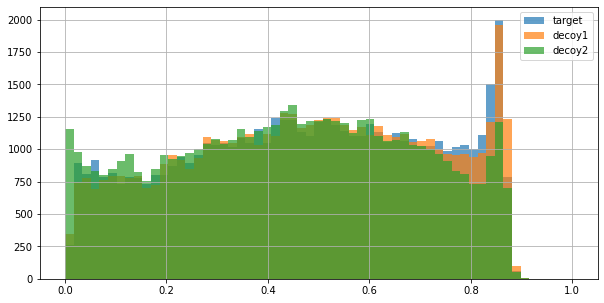

In [8]:
import numpy as np
import matplotlib.pyplot as plt

alpha = 0.7

bins = np.linspace(0,1,60)

plt.figure(figsize=(10,5))

predict_df['rt_pred'].hist(bins=bins,alpha=alpha, label='target')
predict_df_test1['rt_pred'].hist(bins=bins,alpha=alpha, label='decoy1')
predict_df_test2['rt_pred'].hist(bins=bins,alpha=alpha, label='decoy2')

plt.legend()
plt.show()


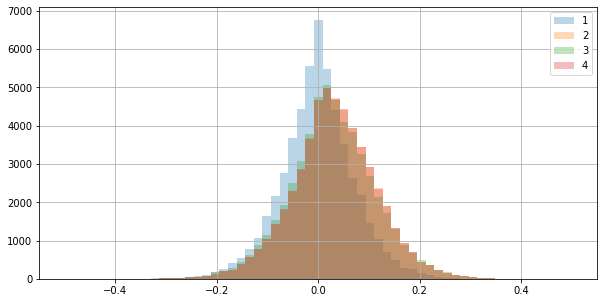

In [9]:
plt.figure(figsize=(10,5))

bins = np.linspace(-0.5,0.5,60)

alpha=0.3

(predict_df['rt_pred']-predict_df_test1['rt_pred']).hist(bins=bins, label='1',alpha=alpha)
(predict_df['rt_pred']-predict_df_test2['rt_pred']).hist(bins=bins, label='2',alpha=alpha)
(predict_df['rt_pred']-predict_df_test3['rt_pred']).hist(bins=bins, label='3',alpha=alpha)
(predict_df['rt_pred']-predict_df_test4['rt_pred']).hist(bins=bins, label='4',alpha=alpha)
plt.legend()

plt.show()